In [ ]:
import os
import re
import warnings

# for analyze data
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')

!pip install pymap3d
import pymap3d as pm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/Kaggle/derby/'

In [ ]:
race_df = pd.read_csv(path+'nyra_race_table.csv')
race_df.head()

,track_id,race_date,race_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time
0,AQU,2019-01-01,1,650,D,MY,36,AOC,80000,1220
1,AQU,2019-01-01,2,600,D,MY,48,MCL,41000,1250
2,AQU,2019-01-01,3,550,D,MY,54,MCL,35000,121
3,AQU,2019-01-01,4,900,D,MY,101,AOC,80000,150
4,AQU,2019-01-01,5,700,D,MY,60,ALW,64000,220


In [ ]:
start_df = pd.read_csv(path+'/nyra_start_table.csv')
start_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14915 entries, 0 to 14914
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   track_id        14915 non-null  object
 1   race_date       14915 non-null  object
 2   race_number     14915 non-null  int64 
 3   program_number  14915 non-null  object
 4   weight_carried  14915 non-null  int64 
 5   jockey          14915 non-null  object
 6   odds            14915 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 815.8+ KB


In [ ]:
track_df = pd.read_csv(path+'nyra_tracking_table.csv')

In [ ]:
track_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   track_id        object 
 1   race_date       object 
 2   race_number     int64  
 3   program_number  object 
 4   trakus_index    int64  
 5   latitude        float64
 6   longitude       float64
dtypes: float64(2), int64(2), object(3)
memory usage: 279.2+ MB


#Analysing the Velcoity and Acceleration of Horses 


In [ ]:
program_num_dict={'5  ':5, '1  ':1, '2  ':2, '3  ':3, '4  ':4, '6  ':6, '7  ':7, '8  ':8, '1A ':17,
       '10 ':10, '9  ':9, '11 ':11, '12 ':12, '13 ':13, '14 ':14, '2B ':20, '16 ':16, '15 ':15,'3X ':18, '1X ':19}
track_df.program_number = track_df.program_number.apply(lambda x: program_num_dict[x])

The program number consists of 3 characters and is a unique identifier of the horse in the race. Here, we are converting the categorical variable program numbers into a numeric variable for further processing.

For getting the average speeds of the horses for different tracks: AQU - Aqueduct, BEL - Belmont and SAR - Saratoga, we define the get_speed function. Then, obtain one-second moving averages for the velocity.

In [ ]:
def get_speed(df,track_id_,debug=False):
    track_id = track_id_
    target_tracking = df.query("track_id == @track_id").sort_values("trakus_index")[['race_date','race_number']].drop_duplicates()
    process_lst = [[target_tracking.at[idx,'race_date'],target_tracking.at[idx,'race_number']] 
                   for idx in target_tracking.index.values]
    if debug==True:
        process_lst = process_lst[:2]
        print(len(process_lst))
    
    temp_df= pd.DataFrame()
    for idx ,process in enumerate(process_lst): 
        if debug==True:
            print(process)
        
        race_date = process[0]
        race_number = process[1]
        target_tracking = df.query("track_id == @track_id & race_date == @race_date & race_number == @race_number").sort_values("trakus_index")

        dtime = 0.25 #0.25 second per trakus_index according to the data description.
        #Elevations obtained from google earth
        if track_id == "AQU":
            elevation = 3
        elif track_id == "BEL":
            elevation = 20
        elif track_id == "SAR":
            elevation = 93

        target_trackings = []
        for number, group in target_tracking.groupby("program_number"):
            ecef = np.array(pm.geodetic2ecef(group["latitude"].values, group["longitude"].values, np.array([elevation]*len(group)))).T
            #Calculate speed [km/h]
            v_ecef = np.sqrt(np.sum(np.diff(ecef,axis=0) ** 2, axis = 1)) * 3.6 / dtime
            
            # Condition:If more than 100 km, replace with the average speed during the race
            condition = v_ecef > 100 
            v_ecef[condition] = np.mean(v_ecef)
            
            group["time"] = group["trakus_index"] * dtime -  dtime
            group["speed"] = np.insert(v_ecef, 0, 0)
            target_trackings.append(group)
            #print("No.", number," Mean speed : {:.2f} km/h".format(np.mean(v_ecef)))
        target_tracking = pd.concat(target_trackings)
        
        if idx ==0:
            temp_df=target_tracking
        else:
            temp_df=temp_df.append(target_tracking)
            
    return temp_df


track_id = "AQU"
AQU_v_df = get_speed(track_df,track_id)

track_id = "BEL"
BEL_v_df = get_speed(track_df,track_id)

track_id = "SAR"
SAR_v_df = get_speed(track_df,track_id)

The speeds are stored in dataframes AQU_v_df, BEL_v_df and SAR_v_df respectively.



In [ ]:
track_v_df=SAR_v_df
track_v_df=track_v_df.append(AQU_v_df)
track_v_df=track_v_df.append(BEL_v_df)
track_v_df=track_v_df.sort_values(by=['track_id','race_date','race_number','program_number','trakus_index'])
track_v_df['speed_prev']=track_v_df['speed'].diff().fillna(0)

Next calculating the acceleration from the previously calculated velocity.<br/>
The summary statistics such as mean, minimum, maximum, standard deviation, and skewness on velocity and acceleration are also deliberated.

In [ ]:
track_v_df['acccelation']= track_v_df['speed_prev']/0.25

track_df_movement = track_v_df.groupby(['track_id','race_date','race_number','program_number']).rolling(window=4).agg(
    {'speed':['mean']
    ,'acccelation':['mean']})

track_df_movement = track_df_movement.reset_index()
col_name=[x[0]+x[1] for x in track_df_movement.columns]
track_df_movement.columns = track_df_movement.columns.droplevel(0)
track_df_movement.columns = col_name
track_df_movement=track_df_movement[track_df_movement['speedmean'].isna()==False]

track_df_movement = track_df_movement.groupby(['track_id','race_date','race_number','program_number']).agg(
    {'speedmean':['mean','min','max','std','skew']
    ,'acccelationmean':['mean','min','max','std','skew']})

track_df_movement=track_df_movement.reset_index()
col_name=[x[0]+x[1] for x in track_df_movement.columns]
track_df_movement.columns = track_df_movement.columns.droplevel(0)
track_df_movement.columns = col_name

start_df['program_number'] = start_df['program_number'].apply(lambda x: program_num_dict[str(x)])
track_df_movement = track_df_movement.merge(start_df)
track_df_movement = track_df_movement.merge(race_df)

pandas.core.groupby.DataFrameGroupBy.agg means aggregate using one or more operations over the specified axis.

###Plotting each of the summary statistics.
Mean Velocity

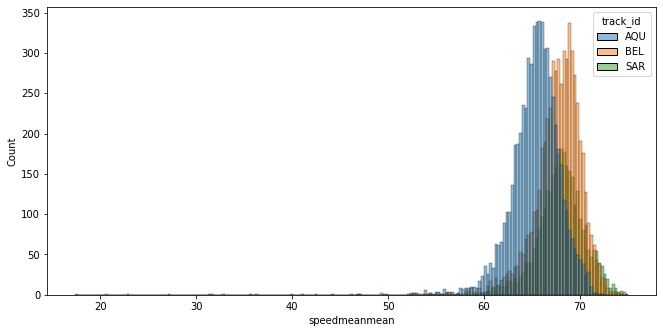

In [ ]:
plt.figure(figsize=[24,18])
plt.subplot(3,2,1)
sns.histplot(data=track_df_movement,x='speedmeanmean',hue='track_id');

Minimum Velocity

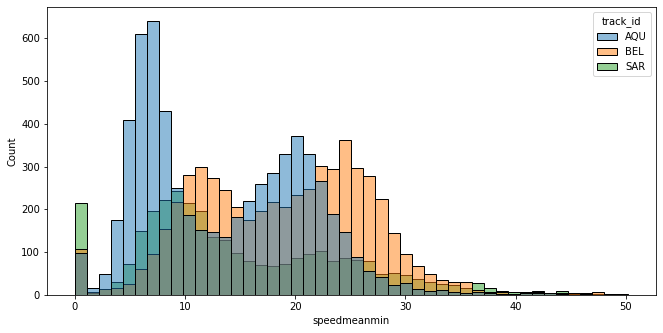

In [ ]:
plt.figure(figsize=[24,18])
plt.subplot(3,2,2)
sns.histplot(data=track_df_movement,x='speedmeanmin',hue='track_id');

Maximum Velocity

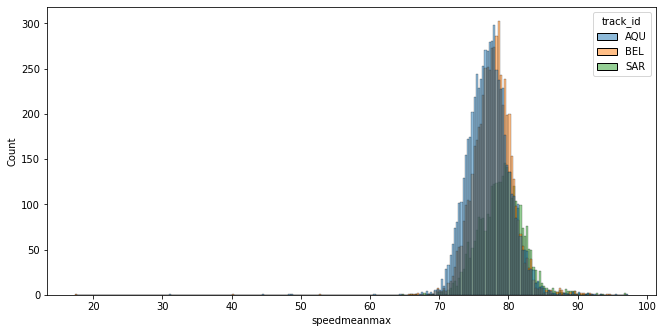

In [ ]:
plt.figure(figsize=[24,18])
plt.subplot(3,2,3)
sns.histplot(data=track_df_movement,x='speedmeanmax',hue='track_id');

Standard Deviation in Velocity

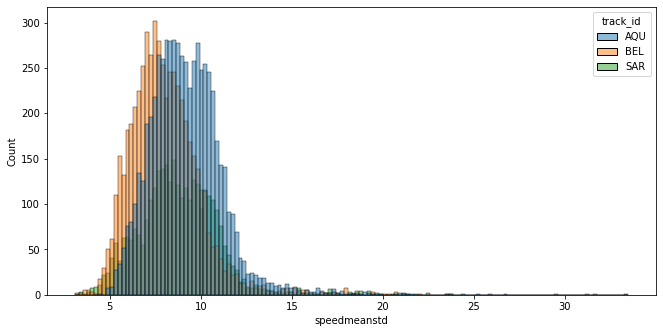

In [ ]:
plt.figure(figsize=[24,18])
plt.subplot(3,2,4)
sns.histplot(data=track_df_movement,x='speedmeanstd',hue='track_id');

Skewness in Velocity

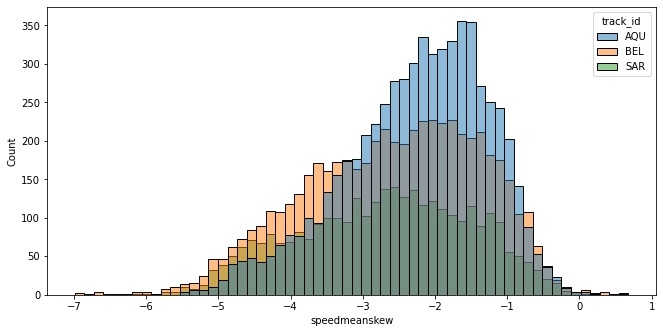

In [ ]:
plt.figure(figsize=[24,18])
plt.subplot(3,2,5)
sns.histplot(data=track_df_movement,x='speedmeanskew',hue='track_id');

###Filtering out statistically anomalous velocity.
In this section, we identify the regular velocity VS the anomalous velocity using the IQR metric. IQR standes for Inter Quartile Range and is a measure of statistical dispersion, which is the spread of the data. <br/>
It is defined as the difference between the 75th and 25th percentiles of the data. To calculate the IQR, the data set is divided into quartiles, or four rank-ordered even parts via linear interpolation. <br/>
These quartiles are denoted by Q1 (also called the lower quartile), Q2 (the median), and Q3 (also called the upper quartile). <br/>
The lower quartile corresponds with the 25th percentile and the upper quartile corresponds with the 75th percentile, so IQR = Q3 − Q1.

In [ ]:
AQU_df=track_df_movement[track_df_movement.track_id=="AQU"]
AQU_df=AQU_df.sample(n=int(AQU_df.shape[0]/10))
#sns.scatterplot(data=AQU_df,x='latitude',y='longitude',hue='course_type');

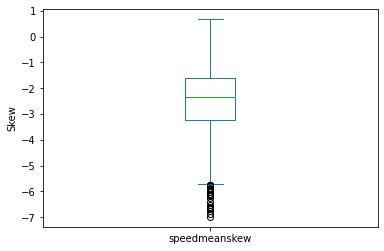

In [ ]:
track_df_movement.speedmeanskew.plot.box();
plt.ylabel('Skew');

We take up only the non-anomalous velocity data points for further analysis.

In [ ]:
IQR=track_df_movement.speedmeanskew.quantile(0.75)-track_df_movement.speedmeanskew.quantile(0.25)
up_wisker=1.5 * IQR + track_df_movement.speedmeanskew.quantile(0.75)
lower_wisker=-1.5 * IQR + track_df_movement.speedmeanskew.quantile(0.25)
track_df_movement_IQR = track_df_movement[(track_df_movement.speedmeanskew>lower_wisker)|(track_df_movement.speedmeanskew<up_wisker)]

###Relationship between average horse speed and odds
The best part of horse racing would be to guess the winning horse. On the other hand you might want to put your money on a horse with high odds. Horses with low odds are supposed to be easier to win, but do they have a higher average speed than the horses in the race? Let's see.

For mean velocity

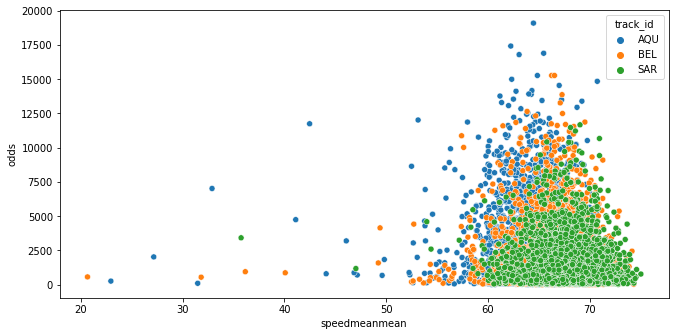

In [ ]:
plt.figure(figsize=[24,18])
plt.subplot(3,2,1)
sns.scatterplot(data=track_df_movement_IQR,x='speedmeanmean',y='odds',hue='track_id');

For Minimum velocity

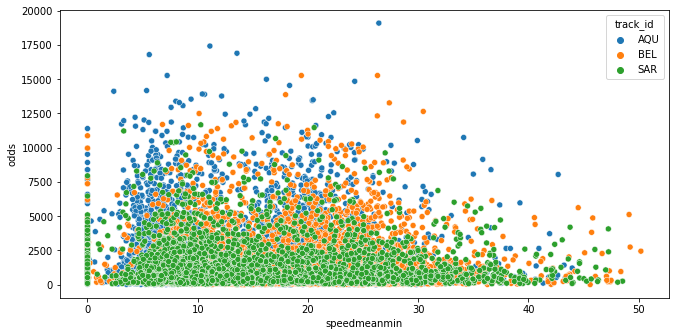

In [ ]:
plt.figure(figsize=[24,18])
plt.subplot(3,2,2)
sns.scatterplot(data=track_df_movement_IQR,x='speedmeanmin',y='odds',hue='track_id');

For maximum velocity

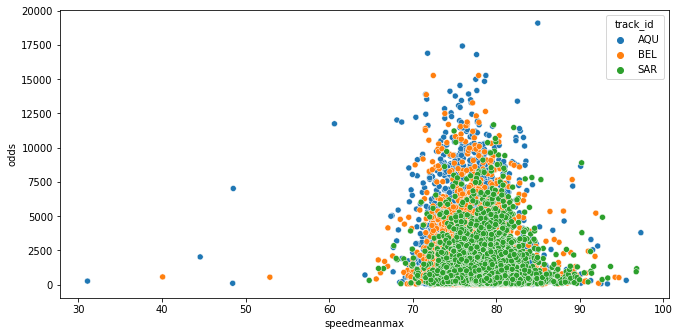

In [ ]:
plt.figure(figsize=[24,18])
plt.subplot(3,2,3)
sns.scatterplot(data=track_df_movement_IQR,x='speedmeanmax',y='odds',hue='track_id');

For standard deviation in velocity

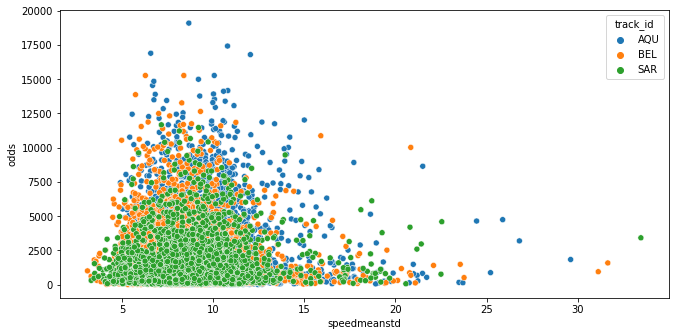

In [ ]:
plt.figure(figsize=[24,18])
plt.subplot(3,2,4)
sns.scatterplot(data=track_df_movement_IQR,x='speedmeanstd',y='odds',hue='track_id');

For skewness in velocity

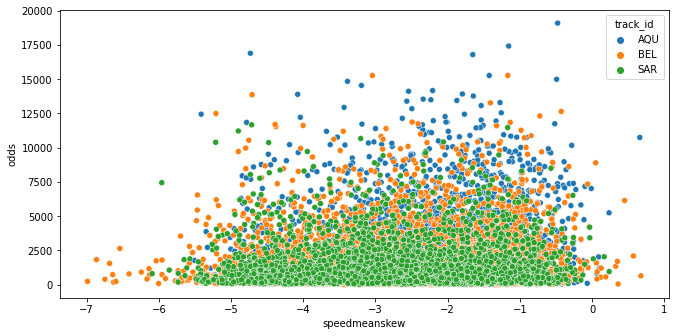

In [ ]:
plt.figure(figsize=[24,18])
plt.subplot(3,2,5)
sns.scatterplot(data=track_df_movement_IQR,x='speedmeanskew',y='odds',hue='track_id');

#Analysing the relation between speed and winning a race. 
Will the fastest horse win? 


In [ ]:
def getrace(df,track_id_,race_date_,race_number_,program_num_):
    horse_df = df[(df['track_id']==track_id_)
         &(df['race_date']==race_date_)
         &(df['race_number']==race_number_)
         &(df['program_number']==program_num_)]
    return horse_df

In [ ]:
temp_df = pd.concat([getrace(track_df,'SAR','2019-08-17',6,5),getrace(track_df,'SAR','2019-08-17',6,10)])

start_df[(start_df['track_id']=='SAR')
         &(start_df['race_date']=='2019-08-17')
         &(start_df['race_number']==6)].sort_values(by='odds').style.background_gradient('Blues')

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds
13897,SAR,2019-08-17,6,8,120,Javier Castellano,80
13894,SAR,2019-08-17,6,5,124,Ricardo Santana Jr.,450
13890,SAR,2019-08-17,6,10,120,Irad Ortiz Jr.,780
13896,SAR,2019-08-17,6,7,120,Jose L. Ortiz,840
13891,SAR,2019-08-17,6,11,120,Jose Lezcano,1110
13889,SAR,2019-08-17,6,1,124,Tyler Gaffalione,1830
13895,SAR,2019-08-17,6,6,118,Joel Rosario,2210
13892,SAR,2019-08-17,6,12,120,Luis Saez,2340
13893,SAR,2019-08-17,6,3,124,Junior Alvarado,3025


The above dataframe indicates the race entered by the horse with the highest average speed that appears to be error free.The horse selected is the horse with 'program_number' of 10. The program_number of the winning horse is 10 and the program_number of the second-placed horse is 5. The odds do not seem very high. Thus, there is no significant relation between speed of the horse and it's odds of winning.

#A glimpse on the course taken by horse
If it wins, what course does it take?

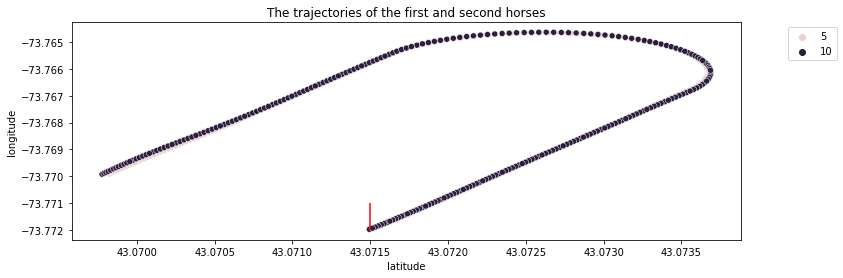

In [ ]:
plt.figure(figsize=[12,4]);
sns.scatterplot(data=temp_df,x='latitude',y='longitude',hue='program_number');
plt.legend(bbox_to_anchor=(1.15, 1));
plt.title('The trajectories of the first and second horses');
plt.vlines(x=43.0715,ymin=-73.772,ymax=-73.771,color='red');

The trajectory taken by the 1st horse is denoted by the black dots and that of the 2nd horse is denoted by the peach dots.<br/>
###Snapshot of trajectory where the first-placed horse overtook the second-placed horse

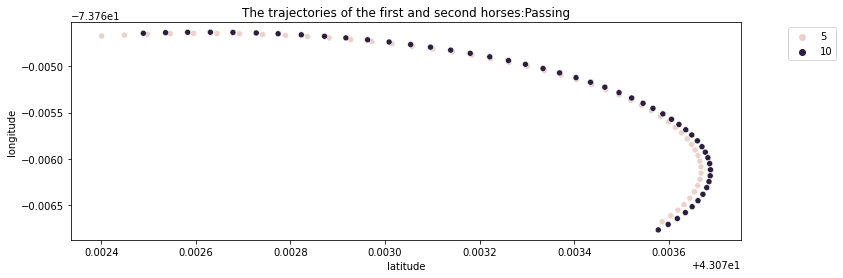

In [ ]:
plt.figure(figsize=[12,4]);
sns.scatterplot(data=temp_df[(temp_df.trakus_index>100)&(temp_df.trakus_index<150)],x='latitude',y='longitude',hue='program_number');
plt.legend(bbox_to_anchor=(1.15, 1));
#plt.vlines(x=43.0715,ymin=-73.772,ymax=-73.771,color='red');
plt.title('The trajectories of the first and second horses:Passing');

The winner horse (w1) overtook the initially leading horse (w2) by moving slightly to the outside of the track and overtaking the w2 in second place from the outside.<br/><br/>
###Zoomed view of the finish line.


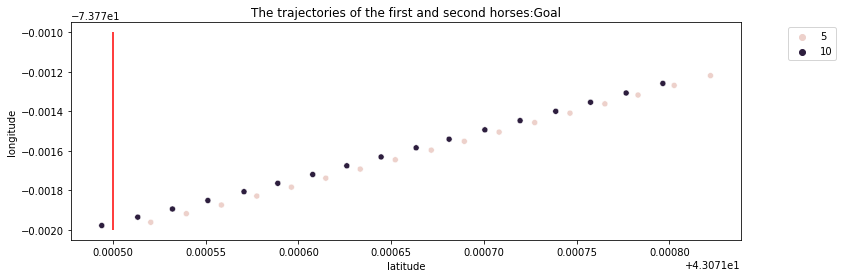

In [ ]:
plt.figure(figsize=[12,4]);
sns.scatterplot(data=temp_df[temp_df.trakus_index>230],x='latitude',y='longitude',hue='program_number');
plt.legend(bbox_to_anchor=(1.15, 1));
plt.vlines(x=43.0715,ymin=-73.772,ymax=-73.771,color='red');
plt.title('The trajectories of the first and second horses:Goal');

The red line is the finish line.